# Portfolio Impact Analysis: LCTD ETF Case Study
**Objective:** This notebook translates the June 2025 GPR spike into a concrete risk assessment for the iShares LCTD ETF, generating the core exhibits for the CFA publication.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

# --- Setup Paths and Imports ---
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

plt.style.use('ggplot')

from gpr_overlay.services.gpr_ingestion_service import load_gpr_daily_from_csv
from gpr_overlay.services.gpr_event_detection_service import detect_gpr_events, select_event_for_target_date
from gpr_overlay.services.portfolio_overlay_service import load_portfolio_snapshot_from_csv, compute_portfolio_industry_exposure
from gpr_overlay.services.industry_impact_service import compute_event_portfolio_impact

# --- Load Data and Run Analysis ---
portfolio_path = os.path.join(project_root, 'data', 'LCTD_portfolio_2025-12-31.csv')
gpr_path = os.path.join(project_root, 'data', 'gpr_daily_sample.csv')

snapshot = load_portfolio_snapshot_from_csv(portfolio_path)
points = load_gpr_daily_from_csv(gpr_path)
events = detect_gpr_events(points, include_regimes=False)

# Select the specific event for the publication exhibit
target_date = date(2025, 6, 23)
chosen_event = select_event_for_target_date(events, target_date)

# Compute the full impact profile
exposures = compute_portfolio_industry_exposure(snapshot)
impact_profile = compute_event_portfolio_impact(chosen_event, exposures)

print(f"Analysis complete for event: {chosen_event.event_type} on {chosen_event.peak_date}")
print(f"Net Portfolio Impact Score: {impact_profile.net_impact:.4f} (or {impact_profile.net_impact*10000:.1f} bps)")

Analysis complete for event: GprEventType.EXTREME_SPIKE on 2025-06-23
Net Portfolio Impact Score: -0.0018 (or -18.4 bps)


## Plot 2.1: Portfolio Industry Composition
This chart shows the basic industry structure of the LCTD ETF, color-coded by GPR vulnerability classification. It helps answer the question: "Where is the portfolio's capital allocated, and how are those allocations classified from a GPR perspective?"

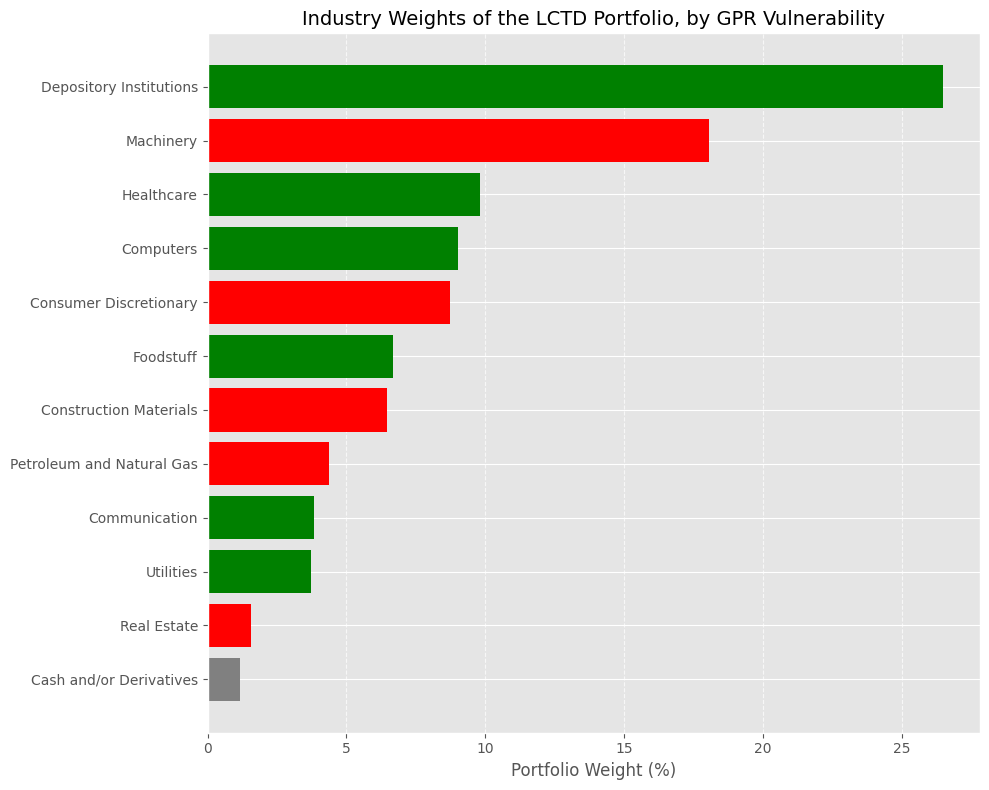

In [2]:
# Prepare data for the bar chart
industries_df = pd.DataFrame([ind.model_dump() for ind in impact_profile.industries])
industries_df = industries_df.sort_values('portfolio_weight', ascending=True)

# Define colors based on direction
color_map = {'negative': 'red', 'positive': 'green', 'neutral': 'gray'}
bar_colors = industries_df['direction'].map(color_map)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(industries_df['fed_industry_name'], industries_df['portfolio_weight'], color=bar_colors)

# Formatting
ax.set_title('Industry Weights of the LCTD Portfolio, by GPR Vulnerability', fontsize=14)
ax.set_xlabel('Portfolio Weight (%)', fontsize=12)
ax.set_ylabel('')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.tick_params(axis='y', labelsize=10)
fig.tight_layout()
plt.show()

## Plot 2.2: Exhibit 2 - Industry Impact in Basis Points
This is the core exhibit, showing which industries contributed positively or negatively to the portfolio's performance during the spike. It directly answers: "Which sectors helped or hurt the most, and by how much?"

C:\Users\victo\AppData\Local\Temp\ipykernel_5280\2081465003.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_vulnerable['impact_bps'] = top_vulnerable['impact_score'] * 10000
C:\Users\victo\AppData\Local\Temp\ipykernel_5280\2081465003.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_resilient['impact_bps'] = top_resilient['impact_score'] * 10000


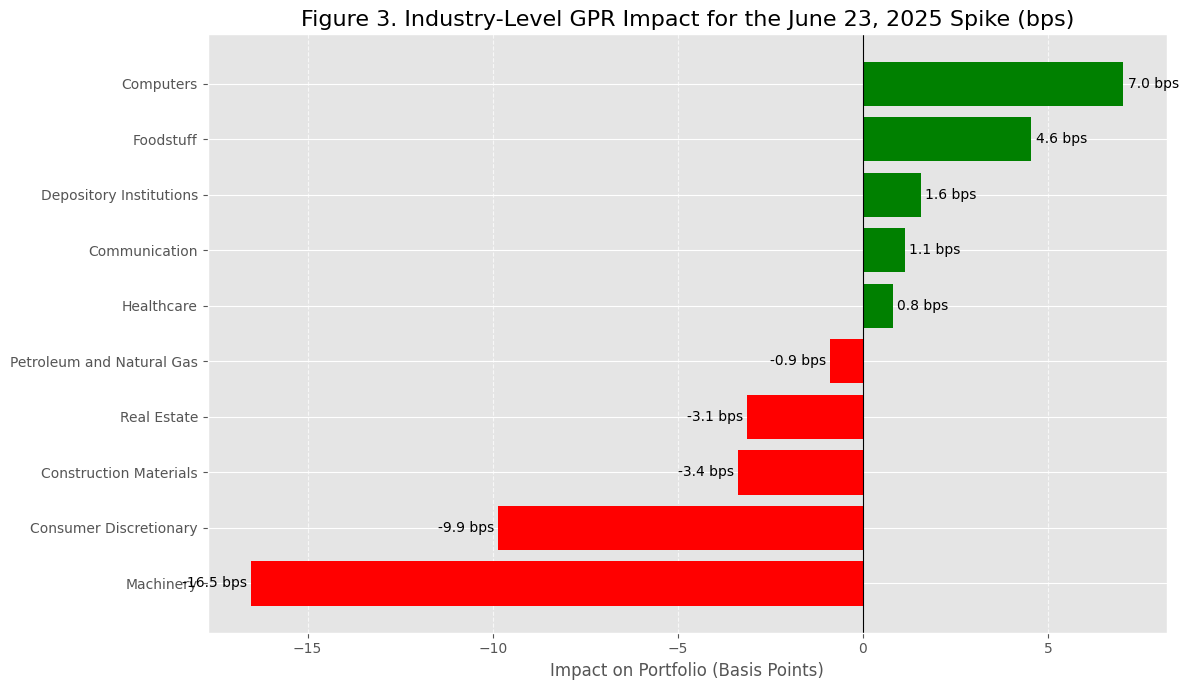

In [3]:
# Prepare data for the impact chart
vulnerable_df = pd.DataFrame([ind.model_dump() for ind in impact_profile.vulnerable_industries])
resilient_df = pd.DataFrame([ind.model_dump() for ind in impact_profile.resilient_industries])

# Take top 5 of each and convert to BPS
top_vulnerable = vulnerable_df.head(5)
top_resilient = resilient_df.head(5)
top_vulnerable['impact_bps'] = top_vulnerable['impact_score'] * 10000
top_resilient['impact_bps'] = top_resilient['impact_score'] * 10000

# Combine and sort for plotting
impact_chart_df = pd.concat([top_resilient, top_vulnerable]).sort_values('impact_bps', ascending=True)

# Define colors
colors = ['green' if x > 0 else 'red' for x in impact_chart_df['impact_bps']]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(impact_chart_df['fed_industry_name'], impact_chart_df['impact_bps'], color=colors)

# Add data labels
ax.bar_label(bars, fmt='%.1f bps', padding=3, fontsize=10)

# Formatting
ax.set_title('Figure 3. Industry-Level GPR Impact for the June 23, 2025 Spike (bps)', fontsize=16)
ax.set_xlabel('Impact on Portfolio (Basis Points)', fontsize=12)
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(axis='x', linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()

## Plot 2.3: Exhibit 3 - Portfolio Vulnerability Composition
This provides a high-level summary of the portfolio's overall risk posture, answering: "What percentage of the portfolio is in vulnerable industries versus non-vulnerable ones?"

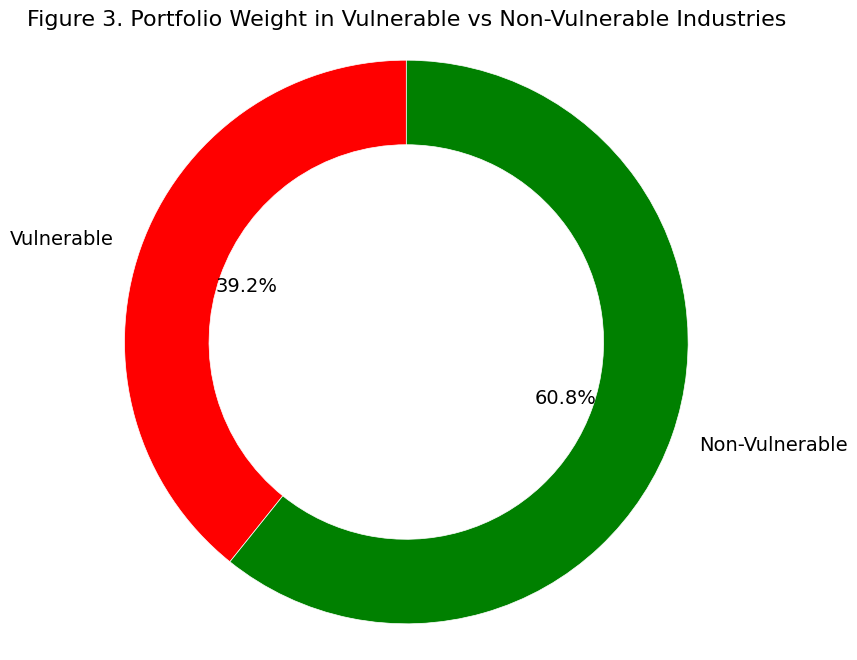

In [4]:
# Prepare data for the donut chart
comp = impact_profile.vulnerability_composition
vulnerable_share = comp.get('vulnerable_weight_share', 0.0)
non_vulnerable_share = 1.0 - vulnerable_share

# Only include slices that are > 0
labels = []
sizes = []
colors = []

if vulnerable_share > 0:
    labels.append('Vulnerable')
    sizes.append(vulnerable_share)
    colors.append('red')
if non_vulnerable_share > 0:
    labels.append('Non-Vulnerable')
    sizes.append(non_vulnerable_share)
    colors.append('green')

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,
       wedgeprops=dict(width=0.3, edgecolor='w'), textprops={'fontsize': 14})

# Formatting
ax.set_title('Figure 3. Portfolio Weight in Vulnerable vs Non-Vulnerable Industries', fontsize=16)
ax.axis('equal')
plt.show()

## Plot 2.4: Appendix - Risk Cartography
This advanced plot maps industry weight against GPR impact, providing a professional risk management view. It helps identify sources of concentrated risk (high weight and high negative impact).

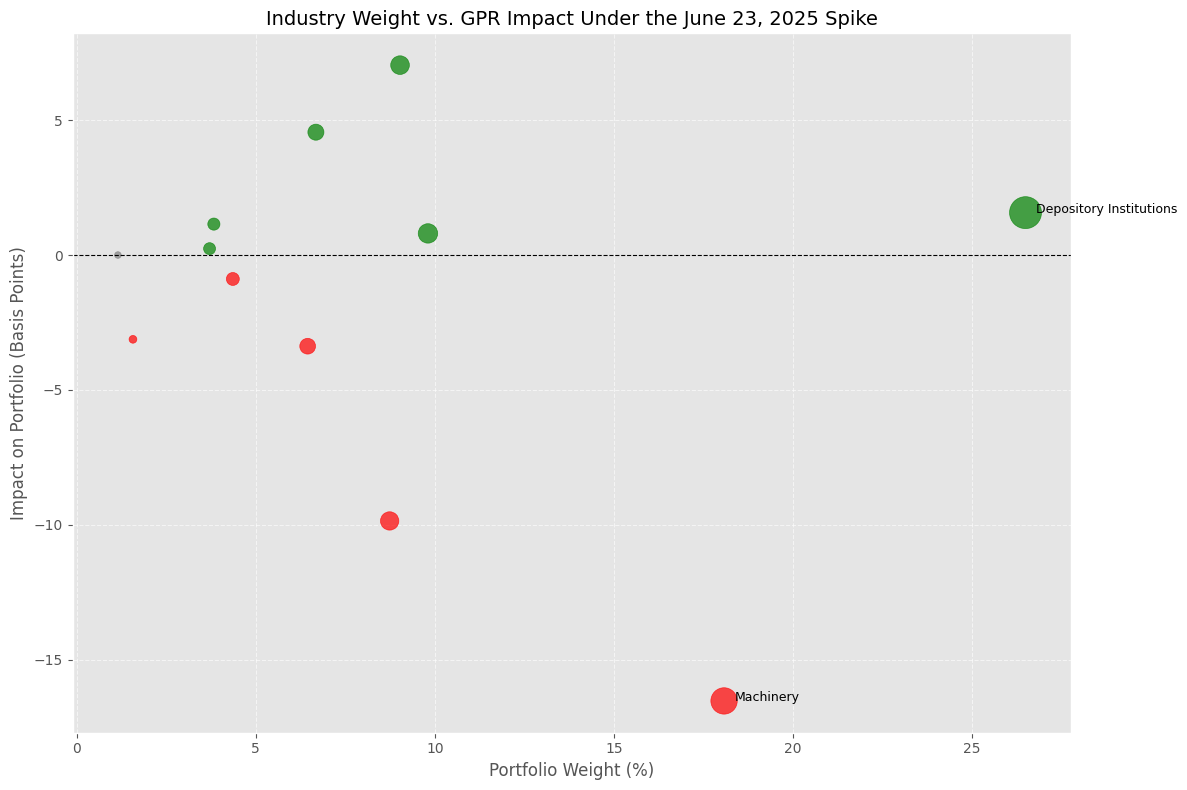

In [5]:
# Prepare data for scatter plot
industries_df['impact_bps'] = industries_df['impact_score'] * 10000

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors
color_map = {'negative': 'red', 'positive': 'green', 'neutral': 'gray'}
colors = industries_df['direction'].map(color_map)

# Plot the scatter
ax.scatter(industries_df['portfolio_weight'], industries_df['impact_bps'], color=colors, s=industries_df['portfolio_weight']*20, alpha=0.7)

# Add the critical zero line
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)

# Annotate key outliers
for i, row in industries_df.iterrows():
    # Annotate industries with high weight or high impact
    if row['portfolio_weight'] > 15 or abs(row['impact_bps']) > 10:
        ax.text(row['portfolio_weight'] + 0.3, row['impact_bps'], row['fed_industry_name'], fontsize=9)

# Formatting
ax.set_title('Industry Weight vs. GPR Impact Under the June 23, 2025 Spike', fontsize=14)
ax.set_xlabel('Portfolio Weight (%)', fontsize=12)
ax.set_ylabel('Impact on Portfolio (Basis Points)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
fig.tight_layout()
plt.show()